# Problem Description

Usually it reaches a moment when time is not on our side. We need to make a quick decision on certain matters as quickly as possible. Developers intending to re-use or implement text searching algorithms often ask themselves on which algorithm we should pick out of the many algorithms available. They manually test each algorithm to find the one providing the fastest speed based on their test case. This is a lengthy process demanding resources and time. We propose a tool in which based on the test case, the user is proposed with the fastest text searching algorithm in no time. This way developers concentrate in more advanced tasks which require human presence and expertise. 

# Data Preprocessing




## Data Load

In [87]:
#!pip install pandas-bokeh
# !pip install ipympl

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import pandas as pd
import seaborn as sns
#import pandas_bokeh
#pandas_bokeh.output_notebook()
# %matplotlib inline
%matplotlib widget

In [3]:
# Dataset URL Parameters
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/muga01/TMAWrapper/main/'
DATASET_PATH = 'dataset'
DATASET_TOKEN = 'token=GHSAT0AAAAAABSP45RAQKOKRPNVVMOB3SUSYRYYGKQ'
DATASET_URL = DOWNLOAD_ROOT + 'dataset/string_pattern_matching.csv?'+DATASET_TOKEN

def fetch_matching_data(dataset_source=DATASET_URL,dataset_dest=DATASET_PATH):
    os.makedirs(dataset_dest,exist_ok=True)
    dataset_file_name = os.path.join(dataset_dest,'string_pattern_matching.csv')
    data = urllib.request.urlretrieve(dataset_source,dataset_file_name)

def load_matching_data(data_source_path=DATASET_PATH):
    csv_path = os.path.join(data_source_path,'string_pattern_matching.csv')
    return pd.read_csv(csv_path)

In [4]:
fetch_matching_data()
matching_data = load_matching_data()
matching_data.head()

,Category,Text Size [MB],Pattern Length,Alphabet Size,Time [ms],Algorithm,Best Algo
0,rand2,1.0,8,2,4.87,AOSO2,NaN
1,rand2,1.0,16,2,1.19,AOSO2,NaN
2,rand2,1.0,32,2,0.56,AOSO2,AOSO2
3,rand2,1.0,64,2,0.58,AOSO2,AOSO2
4,rand2,1.0,128,2,0.57,AOSO2,AOSO2


## Data Cleaning

In [5]:
matching_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3354 entries, 0 to 3353
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        3354 non-null   object 
 1   Text Size [MB]  3354 non-null   float64
 2   Pattern Length  3354 non-null   int64  
 3   Alphabet Size   3354 non-null   int64  
 4   Time [ms]       3354 non-null   float64
 5   Algorithm       3354 non-null   object 
 6   Best Algo       267 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 183.5+ KB


We observe the column Best Algo missing some values. This is intentional as for each test experiment that is for different combinations of [text category, text size, pattern length, alphabet size] each algorithm reports it's speed and among all those speeds the best one is placed under the column Best Algo. We will train our model based on Best Algo label.

# Data Exploration and Visualization

## Dataset High Level Information

In [6]:
matching_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3354 entries, 0 to 3353
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        3354 non-null   object 
 1   Text Size [MB]  3354 non-null   float64
 2   Pattern Length  3354 non-null   int64  
 3   Alphabet Size   3354 non-null   int64  
 4   Time [ms]       3354 non-null   float64
 5   Algorithm       3354 non-null   object 
 6   Best Algo       267 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 183.5+ KB




*   The dataset contains 3354 instances with 7 columns.
*   The dataset has 4 numerical and 3 categorical/string attributes
*The Best Algo column has null values.



## Statistical distribution of numerical attributes

In [7]:
matching_data.describe()

,Text Size [MB],Pattern Length,Alphabet Size,Time [ms]
count,3354.000000,3354.000000,3354.000000,3354.000000
mean,7.995349,84.000000,74.348837,10.197639
std,21.242906,86.638548,78.691502,31.065569
min,1.000000,8.000000,2.000000,0.180000
25%,1.000000,16.000000,8.000000,1.040000
50%,2.000000,48.000000,32.000000,2.335000
75%,4.000000,128.000000,128.000000,5.760000
max,128.000000,256.000000,250.000000,484.560000




*   We have an algorithm(s) which took close to 0.5s to look for a pattern.



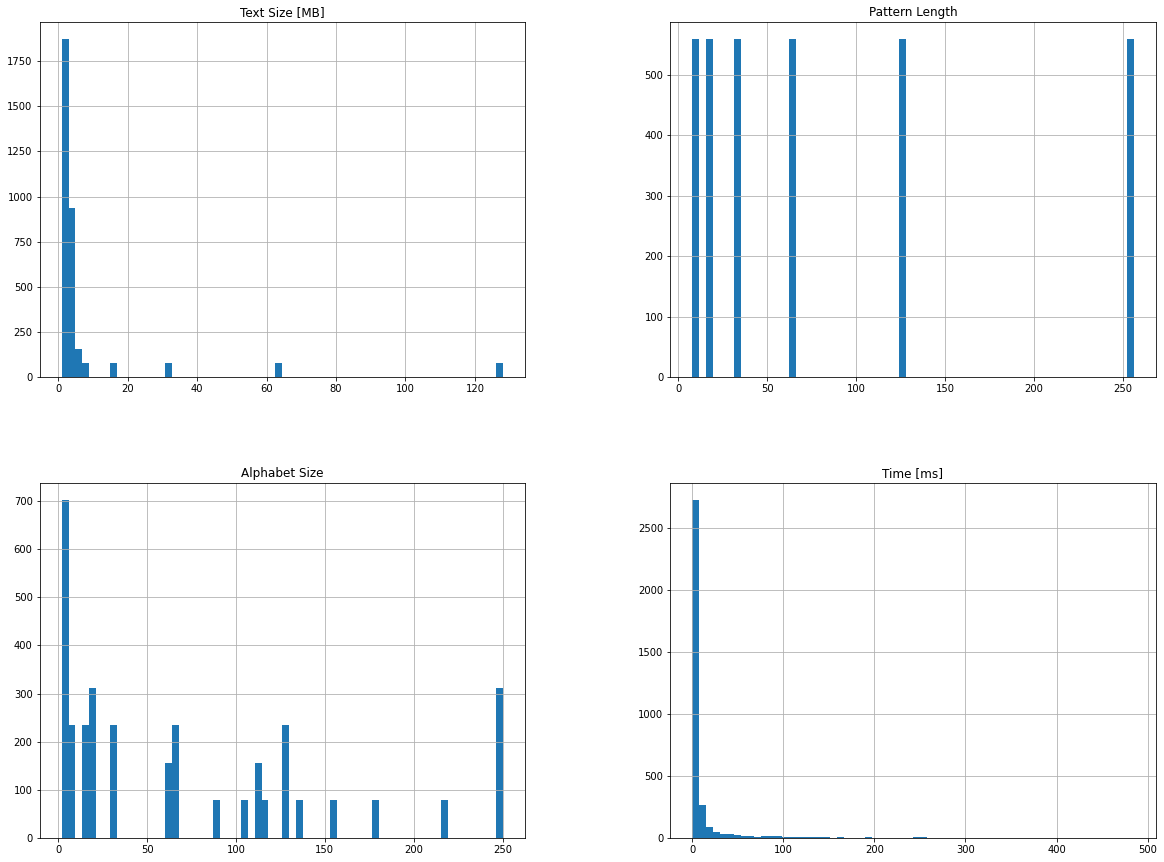

In [92]:
_=matching_data.hist(bins=64,figsize=(20,15))



*   Most of the histograms are tail-heavy, they extend much to the right.
*   The attributes have different scales except pattern length and Alphabet size which looks like they follow the same scale.
* Time attribute follows exponential curve.



## Categorical attributes distribution

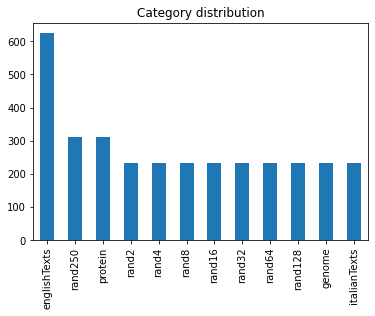

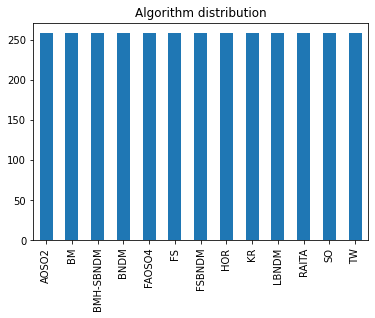

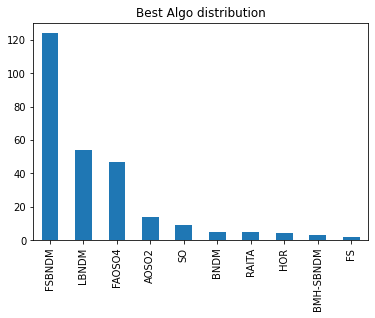

<Figure size 432x288 with 0 Axes>

In [9]:
column_names = ['Category','Algorithm','Best Algo']
for col in column_names:
    plt.title(f'{col} distribution')
    _=matching_data[col].value_counts().plot(kind='bar')
    plt.figure()
    


Starting from top to bottom plot:-
*   Englishtexts category is the most represented, followed by protein and rand250 samples while the rest have equal representation. This is due to the fact that english texts database is bigger than the rest. The text size in MB for englishTexts was set to [1,2,4,8,16,32,64,128], while for rand250 and protein the sizes in MB were set to [1,2,4,8], the rest were set to [1,2,4]. The settings based on two constraints one was the corpus availability and second was the shared memory limitations.
*   Well, nothing much to talk about the second plot. The algorithms are equally represented which means each and every algorithm was tested in each experiment.
* The third plot has a lot to talk about. First, it represents the number of times a particular algorithm beats its competitors in a test experiment. Generally, we observe that FSBNDM algorithm won in most cases while FS was the last. Later we can deep dive into trying to locate under which test cases an algorithm is strong or weak. Second, did you spot that BM,KR, and TW algorithms are missing in the second plot? Well, that means they never won the race in any of the test experiment.



## How long the given algorithm takes for a given pattern length?

In [81]:
#!pip install panel -q # An Interactive Dashboard
from matplotlib.figure import Figure
from matplotlib.ticker import ScalarFormatter
def data_plots(data):
    if data.size == 0:
        return ''

    fig = Figure()
    ax = fig.add_subplot()
    sns.lineplot(data=data,
                 x="Pattern Length",
                 y="Time [ms]",
                 hue='Algorithm',
                 ax=ax,
                 marker='o',
                 estimator='mean')
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True)

    return fig

def group_data(algorithm=["FSBNDM"],textSize=1,category=["englishTexts"],view_fn=data_plots):
    df = matching_data.query('Algorithm in @algorithm & `Text Size [MB]`==@textSize &Category in @category')
    return view_fn(df)

def bestAlgo(df):
    if df.size != 0:
        return pn.pane.Markdown(object=f'Fastest: {df["Algorithm"][0]}')
    return ''
    

def best_algo(category="englishTexts",textSize=1,patternLength=8,alphabetSize=62,view_fn=bestAlgo):
    q = 'Category in @category & `Text Size [MB]`==@textSize & `Pattern Length` ==@patternLength & `Alphabet Size`==@alphabetSize'
    df = matching_data.query(q).sort_values(by='Time [ms]',ignore_index=True)
    return view_fn(df)

def options(txt_size):
    q = matching_data.query('`Text Size [MB]`==@txt_size')
    return sorted(list(q['Alphabet Size'].unique())+[0])

def alpha_options(curr_alpha,curr_size):
    if curr_alpha != 0:
        q = matching_data.query('`Text Size [MB]`==@curr_size & `Alphabet Size`==@curr_alpha')
        return list(q['Category'].unique())
    return list((matching_data['Category'].unique()))

# Defining a parameter Watcher
def callback(*events):
    for event in events:
        if event.name == 'value':
            alphabet_size.options = options(event.new)
            # category.value = category.options = options(event.new)[1]

def callback_alpha(*events):
    for event in events:
        if event.name == 'value':
            category.value = category.options = alpha_options(event.new,text_size.value)
            if event.new == 0: pattern_length.value = 0



            




Row
    [0] Column(width=300)
        [0] Markdown(str)
        [1] MultiSelect(name='Algorithm', options=['AOSO2', 'BM', ...], value=['FSBNDM'])
        [2] Select(name='Text Size', options=[0, 1.0, 2.0, ...], value=1)
        [3] MultiSelect(name='Category', options=['rand2', 'rand4', ...], value=['rand2', 'rand4', ...])
    [1] ParamFunction(function)
    [2] Column(width=200)
        [0] Markdown(str)
        [1] Select(name='Alphabet Size', options=[0, 2, 4, 8, 16, ...], value=0)
        [2] Select(name='Pattern Length', options=[0, 8, 16, 32, ...], value=0)
        [3] ParamFunction(function)
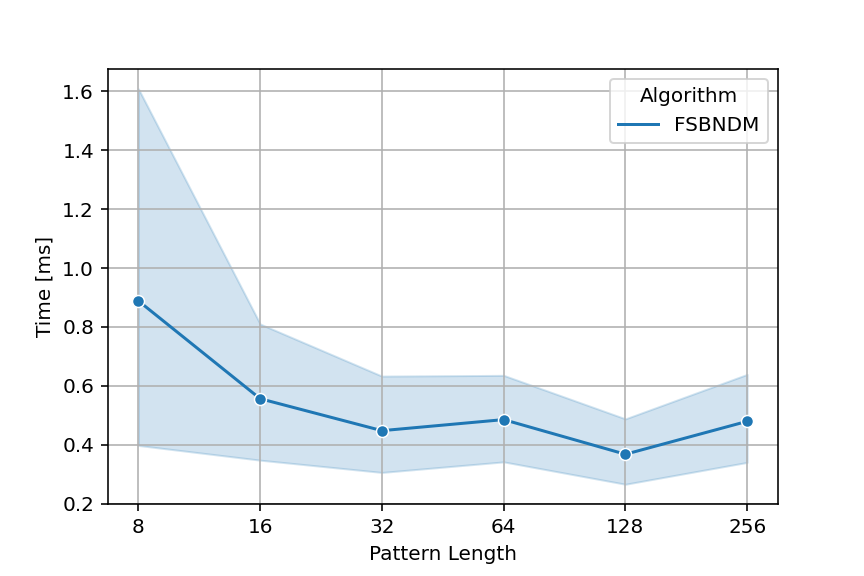

In [98]:
import panel as pn
import panel.widgets as pnw
pn.extension()

algorithm  = pnw.MultiSelect(name='Algorithm', value=['FSBNDM'], 
                                 options=list(matching_data['Algorithm'].unique()))
text_size  = pnw.Select(name='Text Size', value=None, 
                                 options=sorted(list(matching_data['Text Size [MB]'].unique())+[0]))
category = pnw.MultiSelect(name='Category', value=list(matching_data['Category'].unique()),
                           options=list((matching_data['Category'].unique())))
# GROUND TRUTH
text_ground = "\n# Ground truth\nDetermine the fastest algorithm"
alphabet_size = pnw.Select(name='Alphabet Size', value=None,
                                options=sorted(list(matching_data['Alphabet Size'].unique())+[0]))
pattern_length = pnw.Select(name='Pattern Length', value=None,
                                options=sorted(list(matching_data['Pattern Length'].unique())+[0]))
reactive_plot = pn.bind(group_data, algorithm, text_size,category)
best_algo_plot = pn.bind(best_algo,category,text_size,pattern_length,alphabet_size)
truth_column = pn.Column(text_ground,alphabet_size,pattern_length,best_algo_plot,width=200)
text = "\n# Parameter Settings\nApply different set of filters" #<br>
widgets_left   = pn.Column(text, algorithm, text_size,category,width=300) 
smart = pn.Row(widgets_left,reactive_plot,truth_column)
# Register and trig a params watcher, watches text_size
watcher_txt = text_size.param.watch(callback, ['value'], onlychanged=False) 
text_size.value = 1
# Register a params watcher, watches alphabet size
watcher_alpha = alphabet_size.param.watch(callback_alpha, ['value'], onlychanged=False)  
smart


In [104]:
smart.show()

Launching server at http://localhost:34813


# Feature Engineering

# Modeling

# Summary and Conclusion